## Exercise 1

In this exercise, you will use PCA to reduce the MINST data set and visualize the approximation.

### Step 1: Load the data

You don't actually have to do anything here!  Just run the code...

In [ ]:
# @SHOW
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load MNIST data
mnist = fetch_openml("mnist_784", version=1)
X, y = mnist["data"].values, mnist["target"].astype(int).values

# Sample the dataset to speed up computation (Optional)
X, y = X[:7000], y[:7000]

# Split the dataset
X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Step 2: Use PCA to reduce the data set


Visualize your result with a 2d scatter plot, colored by class (the digit identitiy)

In [ ]:
# Your code here


#### Step 3: Scree plot

Calculate and visualize a scree plot for the first 40 component.  The y-axis should be 'percent of variance explained'.

In [ ]:
# Your code here


#### Step 4: Select the number of components


Calculate the number of components required to explain 95% of the variance

In [ ]:
# Your code here


### Step 5: Visualize a digit in the reduced dimensionality space


I've provided a function for visualizing a digit. Figure out how to visualize the same digit using the number of dimensions identified in Step 4.

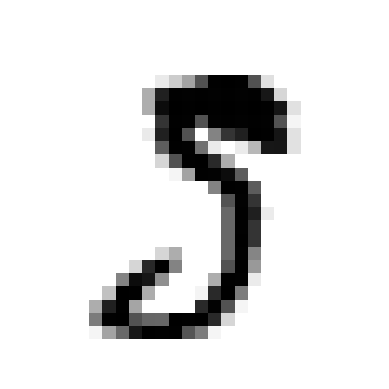

In [ ]:
# @SHOW
def plot_mnist_digit(digit):
    """Plot a single MNIST digit.

    Parameters:
    digit (numpy array): A flattened 1D numpy array of length 784.

    """
    # Reshape the flattened digit to 28x28 image
    digit_image = digit.reshape(28, 28)
    
    plt.imshow(digit_image, cmap='binary')
    plt.axis("off")
    plt.show()

plot_mnist_digit(X_mnist_train[0])

In [ ]:
# Your code here


### Step 6: Use dimensionality reduction to preprocess data


See how a KNN Classifier works with and without dimensionality reduction. Preserve 80% of the variance.

In [ ]:
# Your code here


## Exercise 2
<!-- @q -->
1. Try using t-SNE to visualize the MNIST data above.

In [ ]:
# Your code here


2. Try using a KNN classifier to predict the data with TSNE.  How does it perform?

In [ ]:
# Your code here


## Exercise 3

Try using UMAP to process the MNIST data.  Visualize the data first.

In [ ]:
# @SHOW
# You might need to install UMAP.  If so, uncomment the following lines and run them

# %pip install numpy==2.0
# %pip install umap-learn

In [ ]:
# Your code here


Now, calculate accuracy with KNN.

In [ ]:
# Your code here


## Exercise 4

In the following, I've set up some sample data. Examine the relative performance of PCA and UMAP; for each, try gradually increasing the number of dimensions and examine the impact on KNN. You should also try different parameter settings for UMAP. Make sure to visualize your data after dimensionality reduction to understand what's going on!

Original Data Accuracy: 0.844


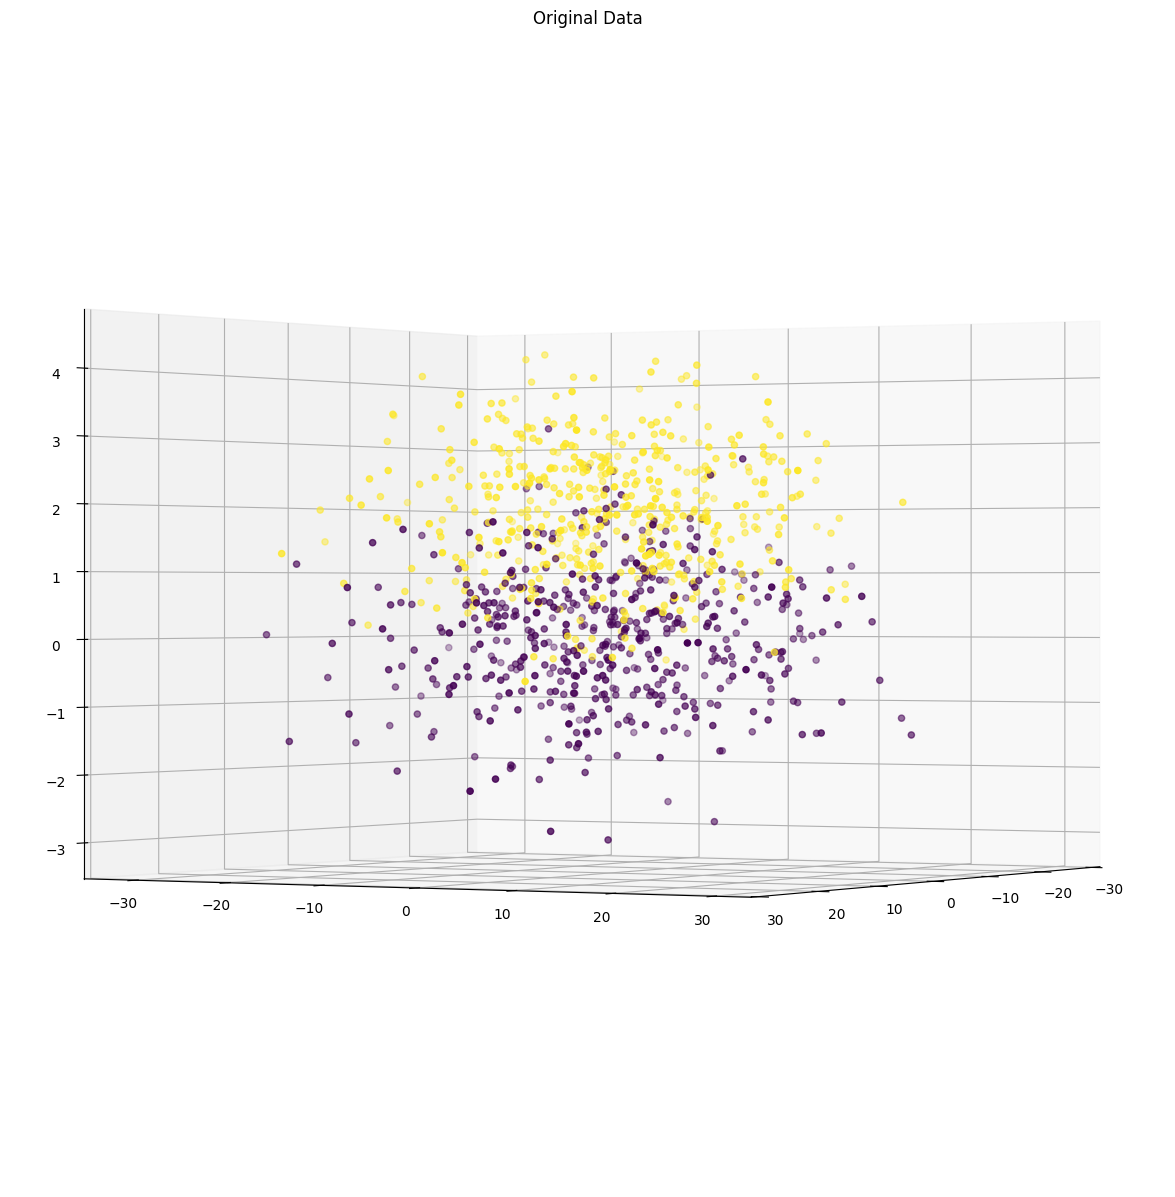

In [ ]:
# @SHOW
# Generate synthetic data
np.random.seed(0)
n_points = 500

# Class 0
x0 = np.random.normal(loc=0, scale=10, size=n_points)
y0 = np.random.normal(loc=0, scale=10, size=n_points)
z0 = np.random.normal(loc=0, scale=1, size=n_points)

# Class 1
x1 = np.random.normal(loc=0, scale=10, size=n_points)
y1 = np.random.normal(loc=0, scale=10, size=n_points)
z1 = np.random.normal(loc=2, scale=1, size=n_points)

X = np.vstack((np.hstack((x0, x1)), np.hstack((y0, y1)), np.hstack((z0, z1)))).T
y = np.hstack((np.zeros(n_points), np.ones(n_points)))



# Train KNN on original data
knn = KNeighborsClassifier()
knn.fit(X, y)
y_pred = knn.predict(X)
print(f"Original Data Accuracy: {accuracy_score(y, y_pred)}")

# Create a new figure
fig = plt.figure(figsize=(15,15))

# Add 3D subplot
# The format is (rows, columns, plot_number)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=0, azim=30)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis')
ax.set_title('Original Data')

plt.show()


In [ ]:
# @SHOW
# Set up train and test, and examine predictions without dimensionality reduction

X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f"Original Data Accuracy: {accuracy_score(y_test, y_pred)}")

Original Data Accuracy: 0.725


1. Try with PCA

In [ ]:
# Your code here


In [ ]:
# Your code here


2. Try with UMAP.

In [ ]:
# Your code here


In [ ]:
# Your code here


Explain your results in the cell below.  Which works better?  Why?

*Enter your answer in this cell*